<a href="https://colab.research.google.com/github/samarth-kashyap/NotebookTemplates/blob/main/mcmc-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install numpyro

In [2]:
import numpy as np

import jax
from jax import jit
from jax import random
import jax.numpy as jnp
from jax.experimental import sparse
from jax.lax import fori_loop as foril
from jax.lax import dynamic_slice as jdc
from jax.lax import dynamic_update_slice as jdc_update
from jax.ops import index_update as jidx_update
from jax.ops import index as jidx

import matplotlib.pyplot as plt

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, SA
from jax.config import config
config.update('jax_enable_x64', True)
jidx_update = jax.ops.index_update
import arviz as az

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [3]:
jidx_update

<function jax._src.ops.scatter.index_update>

In [4]:
rm *.npy

In [5]:
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/data.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/true_params.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/evals_model.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/param_coeff.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/fixed_part.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/acoeffs_true.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/acoeffs_sigma.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/omega0_arr.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/ell0_arr.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/cind_arr.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/sind_arr.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/sparse_idx.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/RL_poly.npy
!wget ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/.dimhyper



--2021-12-01 19:18:12--  ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/data.npy
           => ‘data.npy’
Resolving ftp.tifr.res.in (ftp.tifr.res.in)... 158.144.1.37, 2406:f00:1:1::70
Connecting to ftp.tifr.res.in (ftp.tifr.res.in)|158.144.1.37|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /g.samarth/two-params-mcmc ... done.
==> SIZE data.npy ... 381056
==> PASV ... done.    ==> RETR data.npy ... done.
Length: 381056 (372K) (unauthoritative)

data.npy            100%[===================>] 372.12K   382KB/s    in 1.0s    

2021-12-01 19:18:16 (382 KB/s) - ‘data.npy’ saved [381056]

--2021-12-01 19:18:16--  ftp://ftp.tifr.res.in/g.samarth/two-params-mcmc/true_params.npy
           => ‘true_params.npy’
Resolving ftp.tifr.res.in (ftp.tifr.res.in)... 158.144.1.37, 2406:f00:1:1::70
Connecting to ftp.tifr.res.in (ftp.tifr.res.in)|158.144.1.37|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST

In [6]:
# loading the files forthe problem
data = jnp.asarray(np.load('data.npy'))
true_params = jnp.asarray(np.load('true_params.npy'))
param_coeff = jnp.asarray(np.load('param_coeff.npy'))
fixed_part = jnp.asarray(np.load('fixed_part.npy'))
sparse_idx = jnp.asarray(np.load('sparse_idx.npy'))
acoeffs_true = jnp.asarray(np.load('acoeffs_true.npy'))
acoeffs_sigma = jnp.asarray(np.load('acoeffs_sigma.npy'))
omega0_arr = jnp.asarray(np.load('omega0_arr.npy'))
ell0_arr = jnp.asarray(np.load('ell0_arr.npy'))
eigvals_true = jnp.asarray(np.load('evals_model.npy'))
RL_poly = np.load('RL_poly.npy')
dim_hyper = int(np.loadtxt('.dimhyper'))
OMval = 2.0963670602632024e-05

smin_ind, smax_ind = np.load('sind_arr.npy')
param_coeff = param_coeff[smin_ind:smax_ind+1]
cind_arr = jnp.asarray(np.load('cind_arr.npy'))

s_arr = jnp.array([1, 3, 5], dtype=int)
smin = min(s_arr)
smax = max(s_arr)
num_j = len(s_arr)
nmults = len(ell0_arr)
len_s = true_params.shape[0]
nc = true_params.shape[1]

In [7]:
Pjl_read = RL_poly[:, smin:smax+1:2, :]
Pjl = np.zeros((Pjl_read.shape[0],
                Pjl_read.shape[1],
                dim_hyper))
Pjl[:, :, :Pjl_read.shape[2]] = Pjl_read
Pjl = jnp.asarray(Pjl)
del Pjl_read

Pjl_norm = np.zeros((nmults, Pjl.shape[1]))
for midx in range(nmults):
  Pjl_norm[midx] = np.diag(Pjl[midx] @ Pjl[midx].T)

Pjl_norm = jnp.asarray(Pjl_norm)

Flattening the dimension so that the parameter matrix is a parameter array

In [8]:
true_params = jnp.reshape(true_params, (nc*len_s), 'F')
param_coeff = jnp.reshape(param_coeff, (nc*len_s, nmults, -1), 'F')
param_coeff = jnp.moveaxis(param_coeff, 0, 1)
cmin = 0.7 * true_params
cmax = 1.3 * true_params
print(f"Shape of true_params = {true_params.shape}")
print(f"Shape of param_coeff = {param_coeff.shape}")

Shape of true_params = (8,)
Shape of param_coeff = (5, 8, 10145)


In [9]:
acoeffs_true.shape

(15,)

In [10]:
# setting the upper and lower limits for the uniform prior
def model():
    # sampling from a uniform prior
    c_arr = numpyro.sample('c_arr', dist.Uniform(cmin, cmax))

    pred_acoeffs = jnp.zeros(num_j*nmults)
    pred = c_arr @ param_coeff + fixed_part

    def loop_in_mults(midx, pred_a):
      ell0 = ell0_arr[midx]
      omegaref = omega0_arr[midx]
      pred_dense = sparse.bcoo_todense(pred[midx],
                                       sparse_idx[midx],
                                       shape=(dim_hyper, dim_hyper))
      eigval_mult = get_eigs(pred_dense)/2./omegaref*OMval*1e6
      Pjl_local = Pjl[midx]
      pred_a = jdc_update(pred_a, 
                          (Pjl_local @ eigval_mult)/Pjl_norm[midx],
                          (midx*num_j,))
      return pred_a

    pred_acoeffs = foril(0, nmults, loop_in_mults, pred_acoeffs)
    scaled_diff = (pred_acoeffs - acoeffs_true)/acoeffs_sigma
    return numpyro.factor('obs', dist.Normal(0.0, 1.0).log_prob(scaled_diff))


def eigval_sort_slice(eigval, eigvec):
  def body_func(i, ebs):
    return jidx_update(ebs, jidx[i], jnp.argmax(jnp.abs(eigvec[i])))

  eigbasis_sort = jnp.zeros(len(eigval), dtype=int)
  eigbasis_sort = foril(0, len(eigval), body_func, eigbasis_sort)
  return eigval[eigbasis_sort]

def get_eigs(mat):
  eigvals, eigvecs = jnp.linalg.eigh(mat)
  eigvals = eigval_sort_slice(eigvals, eigvecs)
  return eigvals

In [ ]:
# Start from this source of randomness. We will split keys for subsequent operations.                                                                                                             
seed = int(123 + 100*np.random.rand())
rng_key = random.PRNGKey(seed)
rng_key, rng_key_ = random.split(rng_key)

#kernel = SA(model, adapt_state_size=200)    
kernel = NUTS(model)                                                                                                                     
mcmc = MCMC(kernel, num_warmup=100, num_samples=350)                                                                                                                                    
mcmc.run(rng_key_, extra_fields=('potential_energy',))                                                                                                                                            
pe = mcmc.get_extra_fields()['potential_energy']

warmup:   3%|▎         | 14/450 [39:53<43:09:58, 356.42s/it, 31 steps of size 6.13e-03. acc. prob=0.63]

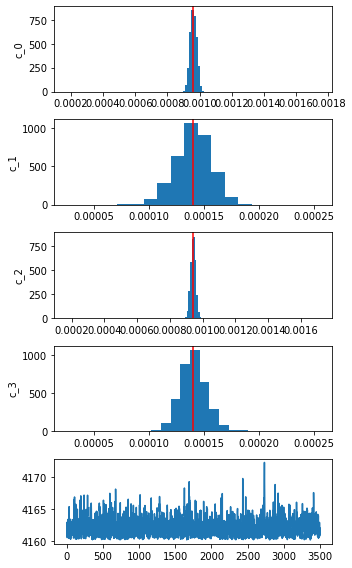

In [ ]:
mcmc_sample = mcmc.get_samples()
keys = mcmc_sample.keys()

fig, axs = plt.subplots(nrows=len(keys)+1, 
                        ncols=1, 
                        figsize=(5, 8))
axs = axs.flatten()
count = 0
for key in keys:
    axs[count].hist(mcmc_sample[f'{key}'])
    axs[count].set_ylabel(f'{key}')
    axs[count].set_xlim([0.1*true_params[count], 
                         1.9*true_params[count]])
    axs[count].axvline(true_params[count], color='r')
    count += 1

axs[count].plot(pe)
fig.tight_layout()

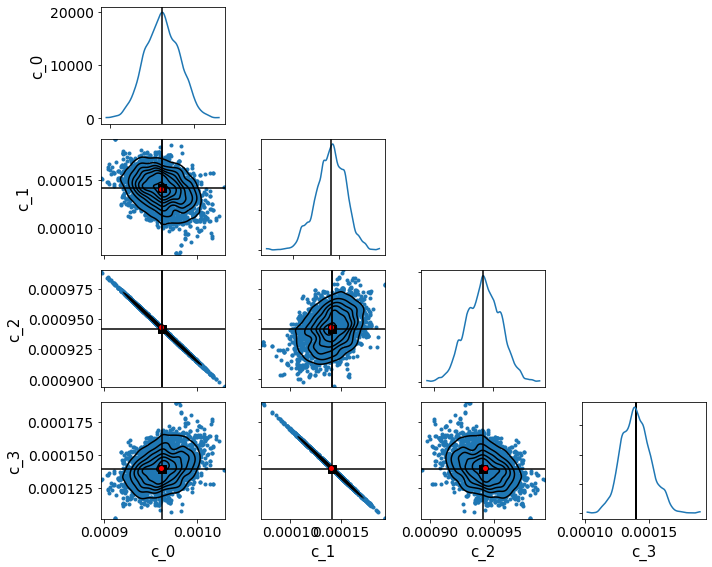

In [ ]:
# putting the true params
refs = {}
refs["c_0"], refs["c_1"], refs["c_2"], refs["c_3"] = true_params

ax = az.plot_pair(
    mcmc_sample,
    var_names=[key for key in mcmc_sample.keys()],
    kde_kwargs={"fill_last": False},
    kind=["scatter", "kde"],
    marginals=True,
    point_estimate="median",
    figsize=(10, 8),
    reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":6}
)
plt.tight_layout()
plt.show()

In [ ]:
# to find the form of the minimization terrain (a nice Gaussian)
len_data = len(data)

def get_posterior_grid(pc):
    N = 100
    fac = jnp.ones((num_params, N))
    fac = jidx_update(fac, jidx[pc, :], 
                      jnp.linspace(0.1, 1.9, N))
    misfit_arr = jnp.zeros(N)
    fac_params = fac * true_params.reshape(num_params, 1)

    def true_func(ic, misfits):
        pred = fixed_part + fac_params[:, ic] @ param_coeff
        misfits = jidx_update(misfits, jidx[ic], 
                              -0.5*np.sum((data - pred)**2)/len_data)
        return misfits

    return fac, foril(0, N, true_func, misfit_arr)

In [ ]:
def get_posterior_grid2d(pc1, pc2):
    num_params = len(true_params)
    N = 100
    fac = jnp.linspace(0.1, 1.9, N)
    misfit_arr = jnp.zeros((N, N))

    
    fac_nonpc = jnp.ones(num_params)
    fac_nonpc = jidx_update(fac_nonpc, jidx[pc1], 0.0)
    fac_nonpc = jidx_update(fac_nonpc, jidx[pc2], 0.0)
    fac = jnp.linspace(0.1, 1.9, N)
    
    fac_params_nonpc = fac_nonpc * true_params

    def true_func_i(i, misfits):
      def true_func_j(j, misfits):
        pred = fixed_part + param_coeff[pc1] * true_params[pc1] * fac[i] +\
                            param_coeff[pc2] * true_params[pc2] * fac[j] +\
                            fac_params_nonpc @ param_coeff
        pred = jax.lax.cond(pc1==pc2,
                            lambda __: pred - param_coeff[pc2] * true_params[pc2] * fac[j],
                            lambda __: pred, 
                            operand=None)

        misfits = jidx_update(misfits, jidx[i, j], 
                              -0.5*np.sum((data - pred)**2)/len_data)
        return misfits
      return foril(0, N, true_func_j, misfits)
    misfits = foril(0, N, true_func_i, misfit_arr)
    return fac, misfits# - misfits.max()

In [ ]:
true_params

DeviceArray([0.00096093, 0.00014028, 0.00094283, 0.00014023], dtype=float64)

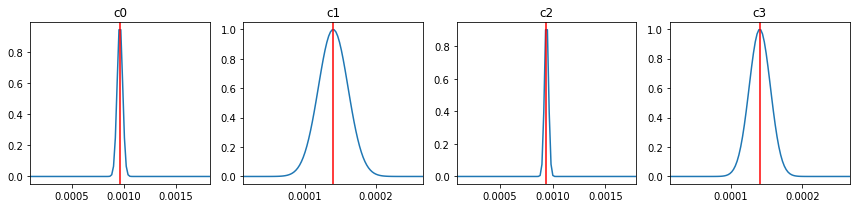

In [ ]:
_get_posterior_grid = jit(get_posterior_grid)

fig, ax = plt.subplots(1, num_params, figsize=(num_params*3, 3))
for i in range(num_params):
  fac, misfit = get_posterior_grid(i)
  # plotting the terrains
  ax[i].plot(fac[i, :] * true_params[i], np.exp(misfit))
  ax[i].set_xlim([cmin[i], cmax[i]])
  ax[i].axvline(true_params[i], color='r')
  ax[i].set_title(f"c{i}")
fig.tight_layout()
fig.show()

0.9515398270639471
0.9972759225647186
0.9524925494421703
0.9143763012057223
0.9999582111192749
0.911218440567175


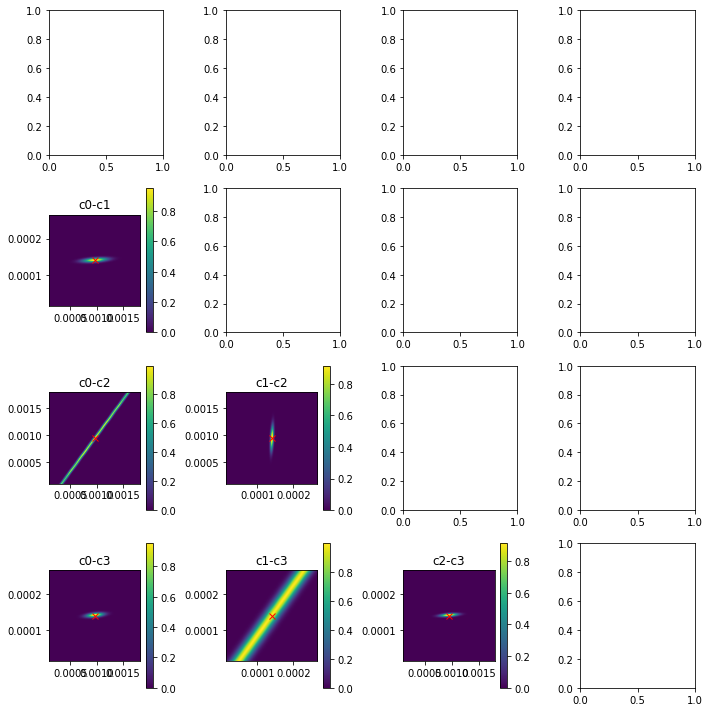

In [ ]:
_get_posterior_grid2d = jit(get_posterior_grid2d)

fig, axs = plt.subplots(nrows=num_params, 
                        ncols=num_params, 
                        figsize=(10, 10))
for i in range(num_params):
  for j in range(i+1, num_params):
    thaxs = axs[j, i]
    fac, misfit_2d = _get_posterior_grid2d(i, j)
    facmin = fac.min()
    facmax = fac.max()
    plotval = np.exp(misfit_2d)
    print(abs(plotval).max())
    im = thaxs.imshow(plotval, extent=[facmin*true_params[i],
                                       facmax*true_params[i],
                                       facmin*true_params[j],
                                       facmax*true_params[j]],
                aspect=abs(true_params[i]/true_params[j]))
    thaxs.plot(true_params[i], true_params[j], 'xr')
    plt.colorbar(im, ax=thaxs)
    thaxs.set_title(f"c{i}-c{j}")
fig.tight_layout()
fig.show()


In [ ]:
fac, misfit_i = get_posterior_grid(0)
fac, misfit_j = get_posterior_grid(1)
mfi = jnp.exp(misfit_i)
mfj = jnp.exp(misfit_j)
misfit_2d = jnp.outer(mfi, mfj)

fac, mf2d = get_posterior_grid2d(0, 1)
mf2d = jnp.exp(mf2d)

In [ ]:
im = plt.imshow(mf2d - misfit_2d)
plt.colorbar(im)